# Project - Inbraakhoofdstad
#### Manus van Kleinwee
---
* Utrecht is in het verleden de **_'inbraakhoofdstad van Nederland'_** genoemd*. Om deze reden lijkt het mij interessant om meer helderheid te krijgen in de inbraakcijfers van de gemeente Utrecht. Per wijk worden de inbraakcijfers bekeken. Er wordt gekeken of er wellicht een samenhang is met de gemiddelde woningwaarde van de verschillende wijken. Over de afgelopen drie maanden worden de inbraakcijfers per week inzichtelijk gemaakt. Ook wordt er gekeken of er verschil is in aantal inbraken tussen de verschillende dagen van de week.
* Er is gebruik gemaakt van misdaadcijfers van politie.nl, van wijk- en buurtstatistieken van het CBS en van geografische data van de gemeente Utrecht.
---
### Bronnen
* Misdaadcijfers uit de tabel van www.politie.nl : https://www.politie.nl/mijn-buurt/misdaad-in-kaart/
* Wijk- en buurtstatistieken van het CBS : https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/_exel/kwb-2019.xls
* Een geojson bestand van de gemeente Utrecht : https://ckan.dataplatform.nl/dataset/5713301f-c5cc-48b3-ae2a-8a107a6129f3/resource/3a85bd19-6836-4e0f-8a27-bd5486632a44/download/wijken-utrecht.geojson
* *https://www.rtvutrecht.nl/nieuws/1856102/utrecht-is-inbraakhoofdstad-van-nederland.html
---

---
### Installeer de packages en importeer de libraries

In [1]:
# Installeer de packages

!pip install lxml
!pip install pgeocode
!pip install geopy
!pip install shapely
!pip install beautifulsoup4

In [2]:
# Importeer de libraries

import pandas as pd
import numpy as np

import pgeocode
import folium
import requests
import datetime
import json
from geopy.geocoders import Nominatim
from shapely.geometry import shape, Point
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
import operator
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy import stats
from math import sqrt
from scipy.stats import t

---
### Creëer het dataframe met de data van het CBS

In [3]:
# Verkrijg het xls bestand van het CBS

xls_url = 'https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/_exel/kwb-2019.xls'
df_xls = pd.read_excel(xls_url, index=False)
df_xls.head()

,gwb_code_10,gwb_code_8,regio,gm_naam,recs,gwb_code,ind_wbi,a_inw,a_man,a_vrouw,...,g_afs_kv,g_afs_sc,g_3km_sc,a_opp_ha,a_lan_ha,a_wat_ha,pst_mvp,pst_dekp,ste_mvs,ste_oad
0,NL00,0,Nederland,Nederland,Land,NL00,.,17282163,8581086,8701077,...,NaN,NaN,NaN,4154338,3367109,787228,.,.,2,1994
1,GM0003,3,Appingedam,Appingedam,Gemeente,GM0003,.,11721,5720,6001,...,NaN,NaN,NaN,2458,2378,80,.,.,3,1067
2,WK000300,300,Wijk 00,Appingedam,Wijk,WK000300,1,11720,5720,6000,...,NaN,NaN,NaN,2458,2378,80,.,.,3,1067
3,BU00030000,30000,Appingedam-Centrum,Appingedam,Buurt,BU00030000,1,2370,1135,1230,...,NaN,NaN,NaN,90,84,5,9901,1,3,1210
4,BU00030001,30001,Appingedam-West,Appingedam,Buurt,BU00030001,1,3035,1505,1530,...,NaN,NaN,NaN,163,158,5,9903,6,4,903


In [4]:
# Filter de data, zodat we enkel de data van de wijken in de stad Utrecht overhouden
df_cbs = df_xls[df_xls['gm_naam'] == "Utrecht"]
df_cbs = df_cbs[df_cbs['recs'] == 'Wijk']

# Verkrijg de kolommen die we zullen gebruiken en geef deze nieuwe namen
df_cbs = pd.DataFrame(df_cbs, columns = ['regio', 'a_inw', 'g_woz'])
df_cbs = df_cbs.rename(columns={"regio": "Wijk", "a_inw": "Aantal inwoners", "g_woz": "Gemiddelde woningwaarde"})

# Reset de index
df_cbs = df_cbs.reset_index(drop=True)

# Geef de wijken een heldere naam (Verwijder 'Wijk 01 ' etc)
df_cbs['Wijk'] = df_cbs['Wijk'].str[8:]

# Zorg dat de kolom 'Gemiddelde woningwaarde' numeriek is en vermenigvuldig met 1000 om zo de correcte gemiddelde woningwaarde weer te geven
df_cbs['Gemiddelde woningwaarde'] = pd.to_numeric(df_cbs['Gemiddelde woningwaarde'])*1000
df_cbs.head()

,Wijk,Aantal inwoners,Gemiddelde woningwaarde
0,West,29400,292000
1,Noordwest,44580,250000
2,Overvecht,34290,177000
3,Noordoost,39265,379000
4,Oost,32505,403000


---
### Download en laad de geografische data van de gemeente Utrecht

In [5]:
# Download het geojson bestand van de wijken van de stad Utrecht

!wget --quiet https://ckan.dataplatform.nl/dataset/5713301f-c5cc-48b3-ae2a-8a107a6129f3/resource/3a85bd19-6836-4e0f-8a27-bd5486632a44/download/wijken-utrecht.geojson -O utrecht.geojson

In [6]:
# Laad het geojson bestand

with open('utrecht.geojson', encoding="latin-1") as f:
    geo = json.load(f)

In [7]:
# Controleer of de namen van de wijken overeenkomen tussen het geojson bestand en het dataframe df_cbs

for i, row in enumerate(df_cbs.values):
    print(geo['features'][i]['properties']['NAAM'], '|', df_cbs['Wijk'][i])

WEST | West
NOORDWEST | Noordwest
OVERVECHT | Overvecht
NOORDOOST | Noordoost
OOST | Oost
BINNENSTAD | Binnenstad
ZUID | Zuid
ZUIDWEST | Zuidwest
LEIDSCHE RIJN | Leidsche Rijn
VLEUTEN - DE MEERN | Vleuten-De Meern


In [8]:
# Maak de namen van de wijken gelijk tussen het geojson bestand en het dataframe df_cbs

for i, row in enumerate(df_cbs.values):
    geo['features'][i]['properties']['NAAM'] = df_cbs['Wijk'][i]
    print(geo['features'][i]['properties']['NAAM'], '|', df_cbs['Wijk'][i])

West | West
Noordwest | Noordwest
Overvecht | Overvecht
Noordoost | Noordoost
Oost | Oost
Binnenstad | Binnenstad
Zuid | Zuid
Zuidwest | Zuidwest
Leidsche Rijn | Leidsche Rijn
Vleuten-De Meern | Vleuten-De Meern


---
### Creëer het dataframe met de misdaadcijfers van politie.nl

In [9]:
# Haal de misdaadcijfers op van Utrecht uit de tabel van www.politie.nl
url_u = 'https://www.politie.nl/mijn-buurt/misdaad-in-kaart/lijst?geoquery=utrecht&pageSize=500'
df_u = pd.read_html(requests.get(url_u).content)[-1]

# Haal de misdaadcijfers op van Haarzuilens, Vleuten en De Meern 
postcodes_hvm = ['3451','3452','3453','3454','3455']

for i in range(len(postcodes_hvm)):
    p = postcodes_hvm[i]
    url_hvm = 'https://www.politie.nl/mijn-buurt/misdaad-in-kaart/lijst?geoquery={}&pageSize=500'.format(p)
    try:
        df_hvm = pd.read_html(requests.get(url_hvm).content)[-1]
    except ValueError:
        df_hvm = pd.DataFrame()
    else:
        if i > 0:
            df_misdaad = df_misdaad.append(df_hvm)
        else:
            df_misdaad = df_hvm

# Voeg de misdaadcijfers samen van Utrecht, Haarzuilens, Vleuten en De Meern 
df_misdaad = df_misdaad.append(df_u, ignore_index=True)
df_misdaad.head()

,Postcodegebied,Datum,Type delict
0,3451,30-04-2020,Woninginbraak
1,3451,23-04-2020,Poging tot woninginbraak
2,3451,24-02-2020,Poging tot woninginbraak
3,3451,24-02-2020,Poging tot woninginbraak
4,3452,04-04-2020,Poging tot woninginbraak


In [10]:
# Verkrijg de coördinaten uit de postcodes

for i, row in enumerate(df_misdaad.values):
    p = str(df_misdaad['Postcodegebied'][i])
    l = pgeocode.Nominatim('nl').query_postal_code(p)
    df_misdaad.loc[i, 'Longitude'] = l.longitude
    df_misdaad.loc[i, 'Latitude'] = l.latitude

# Verkrijg de wijken uit de coördinaten

for i, row in enumerate(df_misdaad.values):
    point = Point(df_misdaad['Longitude'][i],df_misdaad['Latitude'][i])
    for j, row in enumerate(df_cbs.values):
        polygon = shape(geo['features'][j]['geometry'])
        if polygon.contains(point):
            df_misdaad.loc[i, 'Wijk'] = geo['features'][j]['properties']['NAAM']
df_misdaad.head()

,Postcodegebied,Datum,Type delict,Longitude,Latitude,Wijk
0,3451,30-04-2020,Woninginbraak,5.0130,52.1063,Vleuten-De Meern
1,3451,23-04-2020,Poging tot woninginbraak,5.0130,52.1063,Vleuten-De Meern
2,3451,24-02-2020,Poging tot woninginbraak,5.0130,52.1063,Vleuten-De Meern
3,3451,24-02-2020,Poging tot woninginbraak,5.0130,52.1063,Vleuten-De Meern
4,3452,04-04-2020,Poging tot woninginbraak,5.0085,52.0941,Vleuten-De Meern


In [11]:
# Verkrijg de weeknummers en de dagen van de week uit de gegeven datums

for i, row in enumerate(df_misdaad.values):
    y,m,d = int(df_misdaad['Datum'][i][6:10]), int(df_misdaad['Datum'][i][3:5]), int(df_misdaad['Datum'][i][0:2])

# Verkrijg de weeknummers uit de gegeven datums
    df_misdaad.loc[i, 'Weeknummer'] = datetime(y,m,d).isocalendar()[1]
    
# Verkrijg de dagen van de week uit de gegeven datums
    df_misdaad.loc[i, 'Dag van de week'] = datetime(y,m,d).weekday()
    if df_misdaad.loc[i, 'Dag van de week'] == 0:
        df_misdaad.loc[i, 'Dag van de week'] = 'Maandag'
    if df_misdaad.loc[i, 'Dag van de week'] == 1:
        df_misdaad.loc[i, 'Dag van de week'] = 'Dinsdag'
    if df_misdaad.loc[i, 'Dag van de week'] == 2:
        df_misdaad.loc[i, 'Dag van de week'] = 'Woensdag'
    if df_misdaad.loc[i, 'Dag van de week'] == 3:
        df_misdaad.loc[i, 'Dag van de week'] = 'Donderdag'
    if df_misdaad.loc[i, 'Dag van de week'] == 4:
        df_misdaad.loc[i, 'Dag van de week'] = 'Vrijdag'
    if df_misdaad.loc[i, 'Dag van de week'] == 5:
        df_misdaad.loc[i, 'Dag van de week'] = 'Zaterdag'
    if df_misdaad.loc[i, 'Dag van de week'] == 6:
        df_misdaad.loc[i, 'Dag van de week'] = 'Zondag'

# Zet de weeknummers om naar integers
df_misdaad['Weeknummer'] = df_misdaad['Weeknummer'].astype(int)
df_misdaad.head()

,Postcodegebied,Datum,Type delict,Longitude,Latitude,Wijk,Weeknummer,Dag van de week
0,3451,30-04-2020,Woninginbraak,5.0130,52.1063,Vleuten-De Meern,18,Donderdag
1,3451,23-04-2020,Poging tot woninginbraak,5.0130,52.1063,Vleuten-De Meern,17,Donderdag
2,3451,24-02-2020,Poging tot woninginbraak,5.0130,52.1063,Vleuten-De Meern,9,Maandag
3,3451,24-02-2020,Poging tot woninginbraak,5.0130,52.1063,Vleuten-De Meern,9,Maandag
4,3452,04-04-2020,Poging tot woninginbraak,5.0085,52.0941,Vleuten-De Meern,14,Zaterdag


---
### Creëer het dataframe over de wijken door berekeningen uit te voeren over het CBS dataframe

In [12]:
# Geef het aantal woninginbraken en pogingen tot woninginbraken weer in de 'Wijken'-tabel

df_wijken = df_cbs.copy()
for i, row in enumerate(df_wijken.values):
    df_wijken.loc[i, 'Woninginbraken'] = ((df_misdaad['Wijk']==df_cbs['Wijk'][i]) & (df_misdaad['Type delict']=='Woninginbraak')).sum()
    df_wijken.loc[i, 'Pogingen'] = ((df_misdaad['Wijk']==df_cbs['Wijk'][i]) & (df_misdaad['Type delict']=='Poging tot woninginbraak')).sum()

# Zet 'Woninginbraken' en 'Pogingen' om naar integers
df_wijken.loc[:,['Woninginbraken']] = df_wijken['Woninginbraken'].astype(int)
df_wijken.loc[:,['Pogingen']] = df_wijken['Pogingen'].astype(int)

# Bereken het totaal aantal woninginbraken
df_wijken['Totaal'] = df_wijken['Woninginbraken'] + df_wijken['Pogingen']
df_wijken.head()

,Wijk,Aantal inwoners,Gemiddelde woningwaarde,Woninginbraken,Pogingen,Totaal
0,West,29400,292000,18,5,23
1,Noordwest,44580,250000,6,3,9
2,Overvecht,34290,177000,12,8,20
3,Noordoost,39265,379000,12,6,18
4,Oost,32505,403000,21,9,30


In [13]:
# Bereken het aantal woninginbraken, pogingen tot woninginbraken en het totaal per 1000 inwoners

df_wijken['Woninginbraken per 1000'] = df_wijken['Woninginbraken']/(df_wijken['Aantal inwoners']/1000)
df_wijken['Pogingen per 1000'] = df_wijken['Pogingen']/(df_wijken['Aantal inwoners']/1000)
df_wijken['Totaal per 1000'] = df_wijken['Woninginbraken per 1000'] + df_wijken['Pogingen per 1000']

df_wijken.head()

,Wijk,Aantal inwoners,Gemiddelde woningwaarde,Woninginbraken,Pogingen,Totaal,Woninginbraken per 1000,Pogingen per 1000,Totaal per 1000
0,West,29400,292000,18,5,23,0.612245,0.170068,0.782313
1,Noordwest,44580,250000,6,3,9,0.134590,0.067295,0.201884
2,Overvecht,34290,177000,12,8,20,0.349956,0.233304,0.583260
3,Noordoost,39265,379000,12,6,18,0.305616,0.152808,0.458424
4,Oost,32505,403000,21,9,30,0.646054,0.276880,0.922935


---
### Tussenstop
We hebben nu twee dataframes; *df_misdaad* en *df_wijken*. Hier staat alles in wat we nodig hebben aan data. Deze data kan nu visueel worden weergegeven. Er kan gekeken worden of we uit deze data inzichten kunnen onttrekken!

In [14]:
df_misdaad.head()

,Postcodegebied,Datum,Type delict,Longitude,Latitude,Wijk,Weeknummer,Dag van de week
0,3451,30-04-2020,Woninginbraak,5.0130,52.1063,Vleuten-De Meern,18,Donderdag
1,3451,23-04-2020,Poging tot woninginbraak,5.0130,52.1063,Vleuten-De Meern,17,Donderdag
2,3451,24-02-2020,Poging tot woninginbraak,5.0130,52.1063,Vleuten-De Meern,9,Maandag
3,3451,24-02-2020,Poging tot woninginbraak,5.0130,52.1063,Vleuten-De Meern,9,Maandag
4,3452,04-04-2020,Poging tot woninginbraak,5.0085,52.0941,Vleuten-De Meern,14,Zaterdag


In [15]:
df_wijken

,Wijk,Aantal inwoners,Gemiddelde woningwaarde,Woninginbraken,Pogingen,Totaal,Woninginbraken per 1000,Pogingen per 1000,Totaal per 1000
0,West,29400,292000,18,5,23,0.612245,0.170068,0.782313
1,Noordwest,44580,250000,6,3,9,0.134590,0.067295,0.201884
2,Overvecht,34290,177000,12,8,20,0.349956,0.233304,0.583260
3,Noordoost,39265,379000,12,6,18,0.305616,0.152808,0.458424
4,Oost,32505,403000,21,9,30,0.646054,0.276880,0.922935
5,Binnenstad,18650,354000,3,1,4,0.160858,0.053619,0.214477
6,Zuid,27765,247000,14,0,14,0.504232,0.000000,0.504232
7,Zuidwest,38420,219000,12,3,15,0.312337,0.078084,0.390422
8,Leidsche Rijn,38855,328000,4,3,7,0.102947,0.077210,0.180157
9,Vleuten-De Meern,48785,343000,8,5,13,0.163985,0.102491,0.266475


---

In [16]:
# Verkrijg de coördinaten van Utrecht

location = Nominatim(user_agent="to_explorer").geocode('Utrecht, Ut')
latitude = location.latitude
longitude = location.longitude
print('De coördinaten van Utrecht zijn {}, {}.'.format(latitude, longitude))

De coördinaten van Utrecht zijn 52.0949753, 5.109708.


---
### Geografische data
Hier staan twee kaarten weergegeven. Op de eerste kaart wordt duidelijk waar de gemiddelde woningwaarde het hoogst is. Op de tweede kaart wordt duidelijk waar het aantal woninginbraken en pogingen per 1000 inwoners het hoogst is.

In [17]:
# Creëer de kaart welke de gemiddelde woningwaarde weergeeft per wijk
kaart_woningwaarde = folium.Map(location=[latitude, longitude], zoom_start=12)

kaart_woningwaarde.choropleth(
    geo_data=geo,
    data=df_wijken,
    columns=['Wijk', 'Gemiddelde woningwaarde'],
    key_on='feature.properties.NAAM',
    fill_color='BuPu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Gemiddelde woningwaarde'
)

kaart_woningwaarde

In [18]:
# Creëer de kaart welke het aantal woninginbraken en pogingen per 1000 inwoners weergeeft per wijk
kaart_aantalinbraken = folium.Map(location=[latitude, longitude], zoom_start=12)

kaart_aantalinbraken.choropleth(
    geo_data=geo,
    data=df_wijken,
    columns=['Wijk', 'Totaal per 1000'],
    key_on='feature.properties.NAAM',
    fill_color='OrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Aantal woninginbraken en pogingen per 1000 inwoners'
)

kaart_aantalinbraken

---
### Het totaal aantal woninginbraken per 1000 inwoners per wijk
Hier wordt een staafdiagram weergegeven met de verschillende wijken op volgorde van de gemiddelde woningwaarde. Het aantal woninginbraken per 1000 inwoners is te zien met daarop gestapeld het aantal pogingen tot woninginbraken per 1000 inwoners.

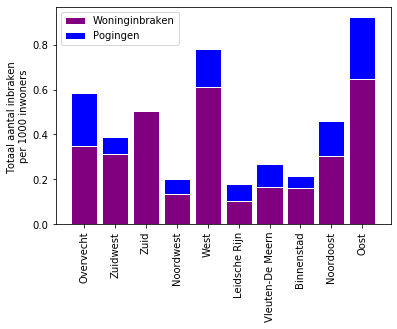

In [19]:
# Geef waardes aan de staven
bars1 = df_wijken.sort_values(by=['Gemiddelde woningwaarde'])['Woninginbraken per 1000']
bars2 = df_wijken.sort_values(by=['Gemiddelde woningwaarde'])['Pogingen per 1000']

# Hoogte van de staven
bars = np.add(bars1, bars2).tolist()
 
# De positie van de staven
r = list(range(0,len(df_wijken)))

# Geef de wijken weer
names = df_wijken.sort_values(by=['Gemiddelde woningwaarde'])['Wijk']
barWidth = .85
 
# Creëer de staven
plt.bar(r, bars1, color='purple', edgecolor='white', width=barWidth)
plt.bar(r, bars2, bottom=list(bars1), color='blue', edgecolor='white', width=barWidth)
 
# Geef de x-as labels weer
plt.xticks(r, names, rotation='vertical')
plt.ylabel('Totaal aantal inbraken \nper 1000 inwoners')
plt.xlabel('')

# Geef de legenda weer
plt.legend(['Woninginbraken','Pogingen'],loc=2)

# Sla de afbeelding op
plt.savefig('barplot1.png', bbox_inches='tight')
 
# Laat de staafdiagram zien
plt.show()

---
### De gemiddelde woningwaarde per wijk en het totaal aantal woninginbraken per 1000 inwoners
Hier wordt een scatterplot weergegeven met de gemiddelde woningwaardes van de verschillende wijken in relatie tot het totaal aantal woninginbraken per 1000 inwoners.

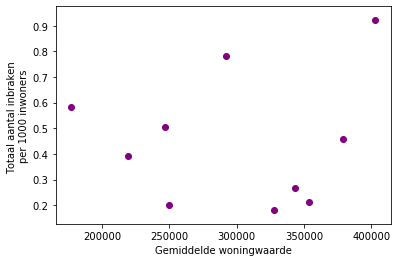

In [20]:
# Geef de waardes aan x en y
x = df_wijken['Gemiddelde woningwaarde']
y = df_wijken['Totaal per 1000']

# Creëer het scatterplot
plt.scatter(x, y, c='purple')

# Geef de labels weer
plt.ylabel('Totaal aantal inbraken \nper 1000 inwoners')
plt.xlabel('Gemiddelde woningwaarde')

# Sla de afbeelding op
plt.savefig('scatterplot1.png', bbox_inches='tight')

# Laat het scatterplot zien
plt.show()

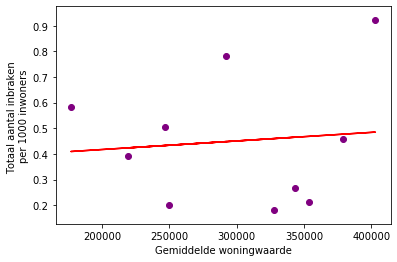

Deze regressie-analyse geeft: 
	R-squared = 0.00948687463156217


In [21]:
# Geef de waardes aan x en y
x = df_wijken['Gemiddelde woningwaarde']
y = df_wijken['Totaal per 1000']

# Creëer het scatterplot
plt.scatter(x, y, c='purple')

# Transformeer de data en bereken de regressielijn
x = x[:, np.newaxis]
y = y[:, np.newaxis]
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Plot de regressielijn
plt.plot(x, y_pred, color='red')

# Geef de labels weer
plt.ylabel('Totaal aantal inbraken \nper 1000 inwoners')
plt.xlabel('Gemiddelde woningwaarde')

# Sla de afbeelding op
plt.savefig('scatterplot2.png', bbox_inches='tight')

# Laat het scatterplot zien
plt.show()

# Bereken de R-squared en geef deze weer
r2 = r2_score(y,y_pred)
print('Deze regressie-analyse geeft: \n\tR-squared = {}'.format(r2))

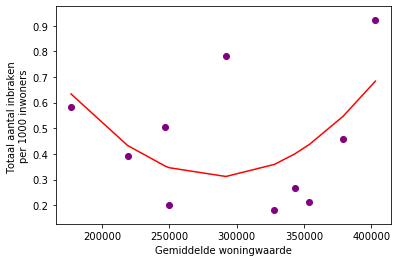

Deze regressie-analyse geeft: 
	R-squared = 0.25473616685721356


In [22]:
# Geef de waardes aan x en y
x = df_wijken['Gemiddelde woningwaarde']
y = df_wijken['Totaal per 1000']

# Transformeer de data en bereken de regressielijn
x = x[:, np.newaxis]
y = y[:, np.newaxis]
polynomial_features= PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(x)
model = LinearRegression()
model.fit(x_poly, y)
y_poly_pred = model.predict(x_poly)

# Creëer het scatterplot
plt.scatter(x, y, color='purple')

# Bereken de R-squared
r2 = r2_score(y,y_poly_pred)

# Sorteer de waardes
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)
x, y_poly_pred = zip(*sorted_zip)

# Geef de labels weer
plt.ylabel('Totaal aantal inbraken \nper 1000 inwoners')
plt.xlabel('Gemiddelde woningwaarde')

# Plot de regressielijn
plt.plot(x, y_poly_pred, color='red')

# Sla de afbeelding op
plt.savefig('scatterplot3.png', bbox_inches='tight')

# Laat het scatterplot zien
plt.show()

# Geef de R-squared weer
print('Deze regressie-analyse geeft: \n\tR-squared = {}'.format(r2))

In [23]:
# Maak een nieuw dataframe uit het misdaad dataframe om het maken van de plots te vergemakkelijken

df_plots = df_misdaad.loc[:,['Wijk','Weeknummer','Dag van de week']]
df_plots.loc[:,'Woninginbraak'] = np.where(df_misdaad['Type delict']=='Woninginbraak', '1', '0')
df_plots.loc[:,'Poging tot woninginbraak'] = np.where(df_misdaad['Type delict']=='Poging tot woninginbraak', '1', '0')
df_plots.head()

,Wijk,Weeknummer,Dag van de week,Woninginbraak,Poging tot woninginbraak
0,Vleuten-De Meern,18,Donderdag,1,0
1,Vleuten-De Meern,17,Donderdag,0,1
2,Vleuten-De Meern,9,Maandag,0,1
3,Vleuten-De Meern,9,Maandag,0,1
4,Vleuten-De Meern,14,Zaterdag,0,1


In [24]:
# Maak het dataframe met de weeknummers en het aantal woninginbraken en pogingen tot woninginbraken

# Maak een lijst van weeknummers, de eerst en laatste weken laten we weg omdat deze incompleet kunnen zijn
weeknummers = list(range(df_plots['Weeknummer'].min()+1, df_plots['Weeknummer'].max()-1))
df_weken = pd.DataFrame(data={'Weeknummer': weeknummers})

# Creëer variabelen voor het aantal woninginbraken en pogingen tot woninginbraken
woninginbraken = df_plots[df_plots['Woninginbraak'] == '1']['Weeknummer'].value_counts()
pogingen = df_plots[df_plots['Poging tot woninginbraak'] == '1']['Weeknummer'].value_counts()

# Creëer loops om weken zonder woninginbraken of pogingen tot woninginbraken te ondervangen
for i, row in enumerate(df_weken.values):
    if df_weken['Weeknummer'][i] in woninginbraken:
        df_weken.loc[i,'Woninginbraken'] = woninginbraken[df_weken['Weeknummer'][i]]
    else:
        df_weken.loc[i,'Woninginbraken'] = 0

for i, row in enumerate(df_weken.values):
    if df_weken['Weeknummer'][i] in pogingen:
        df_weken.loc[i,'Pogingen'] = pogingen[df_weken['Weeknummer'][i]]
    else:
        df_weken.loc[i,'Pogingen'] = 0
        
# Zet 'Woninginbraken' en 'Pogingen' om naar integers
df_weken.loc[:,['Woninginbraken']] = df_weken['Woninginbraken'].astype(int)
df_weken.loc[:,['Pogingen']] = df_weken['Pogingen'].astype(int)

# Bereken het totaal aantal woninginbraken
df_weken['Totaal'] = df_weken['Woninginbraken'] + df_weken['Pogingen']
df_weken

,Weeknummer,Woninginbraken,Pogingen,Totaal
0,8,3,6,9
1,9,12,5,17
2,10,5,0,5
3,11,8,3,11
4,12,10,2,12
5,13,9,2,11
6,14,8,3,11
7,15,5,1,6
8,16,11,2,13
9,17,6,5,11


In [25]:
# Maak het dataframe met de dagen van de week en het aantal woninginbraken en pogingen tot woninginbraken

df_dagen = pd.DataFrame(data={'Dag van de week': ['Maandag','Dinsdag','Woensdag','Donderdag','Vrijdag','Zaterdag','Zondag']})

for i, row in enumerate(df_dagen.values):
    df_dagen.loc[i,'Woninginbraken'] = df_plots[df_plots['Woninginbraak'] == '1']['Dag van de week'].value_counts()[df_dagen['Dag van de week'][i]]
    df_dagen.loc[i,'Pogingen'] = df_plots[df_plots['Poging tot woninginbraak'] == '1']['Dag van de week'].value_counts()[df_dagen['Dag van de week'][i]]

# Zet 'Woninginbraken' en 'Pogingen' om naar integers
df_dagen.loc[:,['Woninginbraken']] = df_dagen['Woninginbraken'].astype(int)
df_dagen.loc[:,['Pogingen']] = df_dagen['Pogingen'].astype(int)

# Bereken het totaal aantal woninginbraken
df_dagen['Totaal'] = df_dagen['Woninginbraken'] + df_dagen['Pogingen']
df_dagen

,Dag van de week,Woninginbraken,Pogingen,Totaal
0,Maandag,17,11,28
1,Dinsdag,24,6,30
2,Woensdag,16,6,22
3,Donderdag,17,3,20
4,Vrijdag,14,9,23
5,Zaterdag,11,6,17
6,Zondag,11,2,13


---
### De dagen van de week, de weeknummers en het totaal aantal woninginbraken
Hier worden twee staafdiagrammen weergegeven. De eerste met de weeknummers van de afgelopen drie maanden. De tweede met de dagen van de week. Het aantal woninginbraken is te zien met daarop gestapeld het aantal pogingen tot woninginbraken.

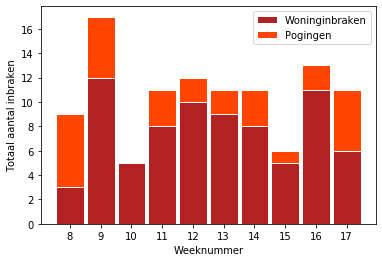

In [26]:
# Geef waardes aan de staven
bars1 = df_weken['Woninginbraken']
bars2 = df_weken['Pogingen']
 
# Hoogte van de staven
bars = np.add(bars1, bars2).tolist()
 
# De positie van de staven
r = list(range(0,len(df_weken)))
 
# Geef de weken weer
names = df_weken['Weeknummer']
barWidth = .9
 
# Creëer de staven
plt.bar(r, bars1, color='firebrick', edgecolor='white', width=barWidth)
plt.bar(r, bars2, bottom=list(bars1), color='orangered', edgecolor='white', width=barWidth)
 
# Geef de labels weer
plt.xticks(r, names)
plt.ylabel('Totaal aantal inbraken')
plt.xlabel('Weeknummer')

# Geef de legenda weer
plt.legend(['Woninginbraken','Pogingen'],loc=1)

# Sla de afbeelding op
plt.savefig('barplot2.png', bbox_inches='tight')
 
# Laat de staafdiagram zien
plt.show()

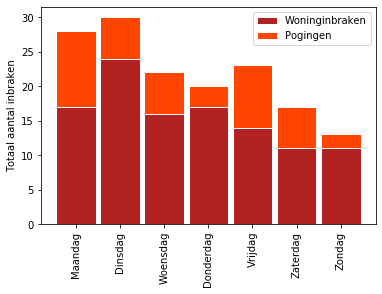

In [27]:
# Geef waardes aan de staven
bars1 = df_dagen['Woninginbraken']
bars2 = df_dagen['Pogingen']
 
# Hoogte van de staven
bars = np.add(bars1, bars2).tolist()
 
# De positie van de staven
r = list(range(0,len(df_dagen)))
 
# Geef de dagen weer
names = df_dagen['Dag van de week']
barWidth = .9
 
# Creëer de staven
plt.bar(r, bars1, color='firebrick', edgecolor='white', width=barWidth)
plt.bar(r, bars2, bottom=list(bars1), color='orangered', edgecolor='white', width=barWidth)
 
# Geef de labels weer
plt.xticks(r, names, rotation='vertical')
plt.ylabel('Totaal aantal inbraken')

# Geef de legenda weer
plt.legend(['Woninginbraken','Pogingen'],loc=1)

# Sla de afbeelding op
plt.savefig('barplot3.png', bbox_inches='tight')

# Laat de staafdiagram zien
plt.show()

---
### Het verschil in totaal aantal inbraken tussen doordeweekse dagen en dagen in het weekend
Hier lijkt erop dat er in het weekend minder wordt ingebroken dan doordeweeks. Met een t-test wordt gekeken of het verschil daadwerkelijk significant is.

In [28]:
# Als voorbereiding creëeren we een nieuw dataframe, waarna we de t-test kunnen uitvoeren

# Verkrijg het aantal inbraken uit het df_misdaad dataframe
df_ttest_totaal = pd.DataFrame(df_misdaad['Datum'].value_counts()).reset_index()
df_ttest_totaal = df_ttest_totaal.rename(columns={"index": "Datum", "Datum": "Inbraken"})

# Zet het dataframe op volgorde van de datums
df_ttest_totaal['Datum_'] = pd.to_datetime(df_ttest_totaal['Datum'], format='%d-%m-%Y')
df_ttest_totaal = df_ttest_totaal.sort_values(by=['Datum_'])
df_ttest_totaal = df_ttest_totaal.drop(['Datum_'], axis=1).reset_index(drop=True)

# De eerste datum is de datum precies drie maanden geleden
datum1 = pd.to_datetime(datetime.today()+relativedelta(months=-3))

# De laatste datum is de laatste datum uit de tabel
datum2 = pd.to_datetime(df_ttest_totaal['Datum'], format='%d-%m-%Y').iloc[-1]+relativedelta(days=1)

# Creëer de range aan datums
df_ttest_datums = pd.date_range(start=datum1, end=datum2)
df_ttest_datums = df_ttest_datums.to_frame(name='Datum')
df_ttest_datums.loc[:,['Datum']] = df_ttest_datums['Datum'].dt.strftime('%d-%m-%Y')
df_ttest_datums = df_ttest_datums.reset_index(drop=True)

# Verkrijg of een datum doordeweeks of in het weekend valt
for i, row in enumerate(df_ttest_datums.values):
    y,m,d = int(df_ttest_datums['Datum'][i][6:10]), int(df_ttest_datums['Datum'][i][3:5]), int(df_ttest_datums['Datum'][i][0:2])    
    if datetime(y,m,d).weekday() <= 4:
        df_ttest_datums.loc[i, 'Dag'] = 'Doordeweeks'
    elif datetime(y,m,d).weekday() >= 5:
        df_ttest_datums.loc[i, 'Dag'] = 'Weekend'

# Creëer het dataframe met de datums en het aantal inbraken
df_ttest = df_ttest_datums.merge(df_ttest_totaal, on='Datum', how='outer')
df_ttest.loc[:,['Inbraken']] = df_ttest['Inbraken'].fillna(0).astype(int)
df_ttest.head()

,Datum,Dag,Inbraken
0,10-02-2020,Doordeweeks,1
1,11-02-2020,Doordeweeks,8
2,12-02-2020,Doordeweeks,10
3,13-02-2020,Doordeweeks,2
4,14-02-2020,Doordeweeks,3


In [29]:
# Maak variabelen voor de doordeweekse dagen en voor de dagen in het weekend met het totaal aantal inbraken
doordeweeks = df_ttest['Inbraken'][df_ttest['Dag'] == 'Doordeweeks']
weekend = df_ttest['Inbraken'][df_ttest['Dag'] == 'Weekend']

# Voer de independent t-test uit
ind_t_test = stats.ttest_ind(doordeweeks,weekend)

# Bereken de gemiddelde verschillen en het 95% confidence interval
N1 = df_ttest['Dag'].value_counts()['Doordeweeks']
N2 = df_ttest['Dag'].value_counts()['Weekend']
df = (N1 + N2 - 2)
std1 = doordeweeks.std()
std2 = weekend.std()
std_N1N2 = sqrt( ((N1 - 1)*(std1)**2 + (N2 - 1)*(std2)**2) / df) 

diff_mean = doordeweeks.mean() - weekend.mean()
MoE = t.ppf(0.975, df) * std_N1N2 * sqrt(1/N1 + 1/N2)

print('De resultaten van de onafhankelijke t-test zijn: \n\tt-waarde = {:4.3f}\n\tp-waarde = {:4.3f}'.format(ind_t_test[0],ind_t_test[1]))
print ('\nHet verschil in aantal inbraken tussen een doordeweekse dag en \neen dag in het weekend is {:3.1f} [{:3.1f} - {:3.1f}] (gemiddelde [95% CI])'.format(diff_mean, diff_mean - MoE, diff_mean + MoE))

De resultaten van de onafhankelijke t-test zijn: 
	t-waarde = 1.645
	p-waarde = 0.104

Het verschil in aantal inbraken tussen een doordeweekse dag en 
een dag in het weekend is 0.7 [-0.1 - 1.6] (gemiddelde [95% CI])
